In [1]:
import pandas as pd
import networkx as nx

import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.bundling import hammer_bundle
from datashader.layout import forceatlas2_layout 

from sklearn.preprocessing import LabelEncoder

C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Load data

In [2]:
df = pd.read_csv('../output/Chess.com/final_df_min10.csv')

Directed Graph

In [3]:
G = nx.DiGraph()
for _, row in df.iterrows():
    white_player = row['white_username']
    black_player = row['black_username']
    if row['white_result'] == '1':
        if G.has_edge(white_player, black_player):
            G[white_player][black_player]['weight'] += 1
        else:
            G.add_edge(white_player, black_player, weight=1)
    if row['black_result'] == '1':
        if G.has_edge(black_player, white_player):
            G[black_player][white_player]['weight'] += 1
        else:
            G.add_edge(black_player, white_player, weight=1)
    if row['white_result'] == '½':
        if G.has_edge(black_player, white_player):
            G[black_player][white_player]['weight'] += 0.5
        if G.has_edge(white_player, black_player):
            G[white_player][black_player]['weight'] += 0.5
        elif not G.has_edge(black_player, white_player):
            G.add_edge(black_player, white_player, weight=0.5)
        elif not G.has_edge(white_player, black_player):
            G.add_edge(white_player, black_player, weight=0.5)

In [4]:
G.number_of_nodes(), G.number_of_edges()

(863, 15881)

In [5]:
nx.find_cycle(G)

[('DenLaz', 'GlavkonVVS'), ('GlavkonVVS', 'DenLaz')]

Plot Network

In [6]:
pos = nx.kamada_kawai_layout(G)

### Datashader Network

In [7]:
cvsopts = dict(plot_height=800, plot_width=800)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)

def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

Generate datashader dataframe

In [8]:
nodes = pd.DataFrame({'x': [coords[0] for coords in pos.values()],'y': [coords[1] for coords in pos.values()]})

edges = list(zip([edge[0] for edge in G.edges()], [edge[1] for edge in G.edges()])) 
edges_df = pd.DataFrame(edges, columns=['source', 'target'])

le = LabelEncoder()
le.fit(G.nodes())

edges_df['source'] = le.transform(edges_df['source'])
edges_df['target'] = le.transform(edges_df['target'])

Graph datashader networks

Force-Directed Edge Bundling of 2023-2024 Chess.com Titled Tuesday Win Network,Edge Bundling of 2023-2024 Chess.com Titled Tuesday Win Network

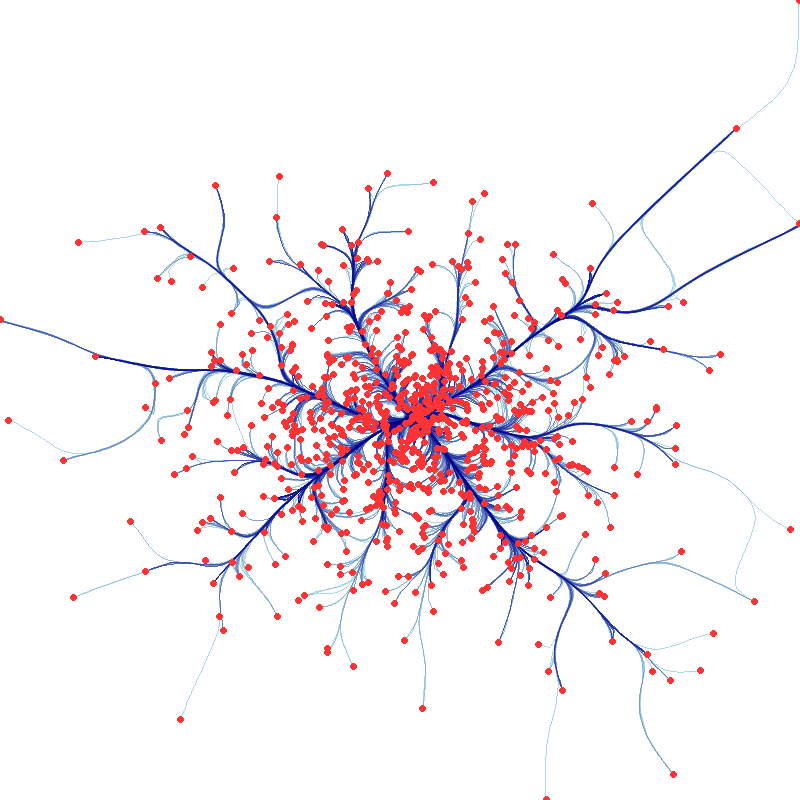
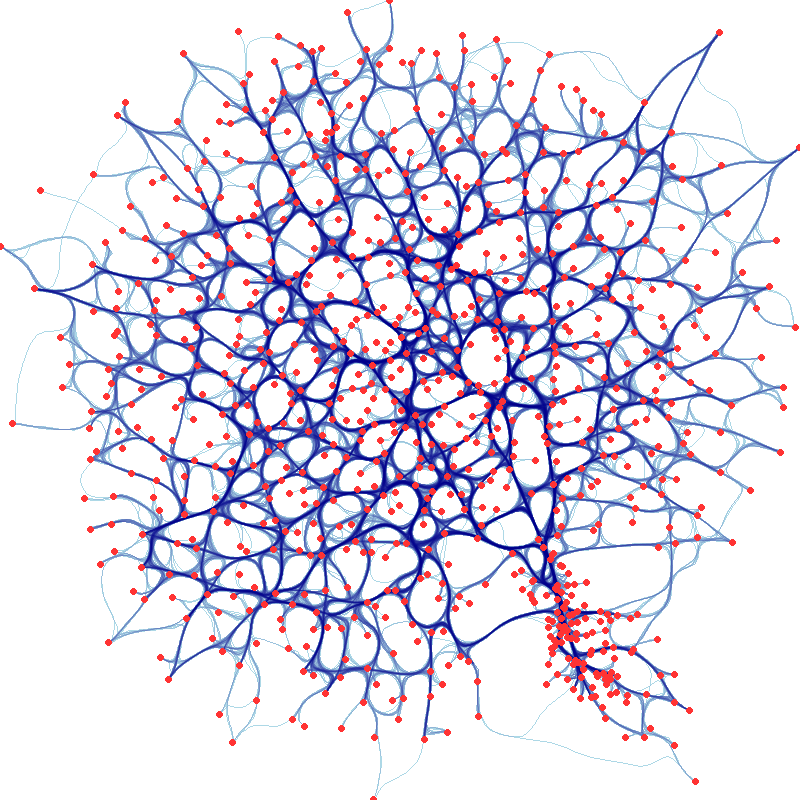

In [9]:
hb_plot = graphplot(nodes, hammer_bundle(nodes, edges_df, initial_bandwidth=0.02), "Edge Bundling of 2023-2024 Chess.com Titled Tuesday Win Network")

fd = forceatlas2_layout(nodes, edges_df)
fd_c = graphplot(nodes=fd, edges=hammer_bundle(fd, edges_df, initial_bandwidth=0.08), name="Force-Directed Edge Bundling of 2023-2024 Chess.com Titled Tuesday Win Network")

tf.Images(fd_c, hb_plot)

In [10]:
cvsopts = dict(plot_height=1400, plot_width=1400)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator = None if cat is None else ds.count_cat(cat)
    agg = canvas.points(nodes, 'x', 'y', aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x', 'y', agg=ds.count()), name=name)

def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = (nodes.x.min(), nodes.x.max())
        yr = (nodes.y.min(), nodes.y.max())
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

def export_graph_image(nodes, edges, filename='', cat=None):
    img = graphplot(nodes, edges, cat=cat)  
    export_image(img=img, filename=filename, fmt=".png", background='white')

In [11]:
export_graph_image(nodes, hammer_bundle(nodes, edges_df, initial_bandwidth=0.02), filename='../output/Chess.com/chess_edge_bundles')

In [12]:
export_graph_image(fd, hammer_bundle(fd, edges_df, initial_bandwidth=0.08), filename='../output/Chess.com/chess_fd_edge_bundling')